**1. Downloading the Corpus**

---



In [0]:
import nltk
nltk.download('punkt')
nltk.download('gutenberg')
from nltk.corpus import gutenberg
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


Sanity check :

In [0]:
print(len(austen))

16498


**2. Preprocessing the Training Corpus**

---



Stopwords, numbers and punctuations removal. Also removing sentences with length less than 2 words.

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
stopWords = set(stopwords.words('english'))

def pre_process(corpus):
  normalised_corpus = [] 
  for lines in austen:
    wordsFiltered = []
    for words in lines:
      lower = words.lower()
      if lower not in stopWords and lower.isalpha():
        wordsFiltered.append(lower)
    final = " ".join(wordsFiltered)
    if len(final.strip().split())>2:  
      normalised_corpus.append(final.strip())
  return normalised_corpus

normalised_corpus = pre_process(austen)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
print('Length of processed corpus:', len(normalised_corpus))

Length of processed corpus: 13923


In [0]:
print('Processed line:', normalised_corpus[10])

Processed line: therefore succession norland estate really important sisters fortune independent might arise father inheriting property could small


**3. Creating the Corpus Vocabulary and Preparing the Dataset.**

In [0]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(normalised_corpus)
word2idx = tokenizer.word_index
word2idx["<PAD>"] = 0

idx2word = {}
for key, value in word2idx.items():
  idx2word[value] = key

sents_as_ids = tokenizer.texts_to_sequences(normalised_corpus)
word_ids = tokenizer.word_index
vocab_size = len(word_ids) + 1 # 1 was added for zero padding
embed_size = 100 # We are creating 100D embeddings.


Sanity Check:

In [0]:
print("Number of unique words:", len(word_ids))

Number of unique words: 10085


In [0]:
print('\nSample word2idx: ', list(word2idx.items())[:10])


Sample word2idx:  [('could', 1), ('would', 2), ('mr', 3), ('mrs', 4), ('must', 5), ('said', 6), ('one', 7), ('much', 8), ('miss', 9), ('every', 10)]


In [0]:
print('\nSample idx2word:', list(idx2word.items())[:10])


Sample idx2word: [(1, 'could'), (2, 'would'), (3, 'mr'), (4, 'mrs'), (5, 'must'), (6, 'said'), (7, 'one'), (8, 'much'), (9, 'miss'), (10, 'every')]


In [0]:
print('\nSample normalized corpus:', normalised_corpus[:3])


Sample normalized corpus: ['sense sensibility jane austen', 'family dashwood long settled sussex', 'estate large residence norland park centre property many generations lived respectable manner engage general good opinion surrounding acquaintance']


In [0]:
print('\nAbove sentence as a list of ids:' , sents_as_ids[:3])


Above sentence as a list of ids: [[305, 1379, 75, 4292], [108, 101, 57, 333, 2586], [1022, 404, 1626, 597, 554, 2784, 1023, 66, 4293, 511, 768, 160, 1164, 199, 15, 190, 3041, 147]]


**4. Generating training instances**

---



In [0]:
from keras.preprocessing.sequence import skipgrams
skip_grams = [skipgrams(sent, vocabulary_size=vocab_size, window_size=5) for sent in sents_as_ids]

Sanity Check:

In [0]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(len(pairs)):
  print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
  # the first word and its index
  idx2word[pairs[i][0]], pairs[i][0],
  # the second word and its index
  idx2word[pairs[i][1]], pairs[i][1],
  # the label
  labels[i]))

(sense (305), tame (4326)) -> 0
(jane (75), drinking (2691)) -> 0
(sense (305), sooth (6954)) -> 0
(austen (4292), dessert (4783)) -> 0
(austen (4292), surely (1958)) -> 0
(austen (4292), sensibility (1379)) -> 1
(sense (305), austen (4292)) -> 1
(sensibility (1379), dating (8742)) -> 0
(jane (75), sensibility (1379)) -> 1
(jane (75), austen (4292)) -> 1
(austen (4292), sense (305)) -> 1
(sensibility (1379), sense (305)) -> 1
(jane (75), sense (305)) -> 1
(sense (305), sensibility (1379)) -> 1
(jane (75), refuted (8100)) -> 0
(sensibility (1379), plunged (9983)) -> 0
(sense (305), jane (75)) -> 1
(sensibility (1379), circumventing (9884)) -> 0
(austen (4292), faintness (6970)) -> 0
(austen (4292), jane (75)) -> 1
(sensibility (1379), jane (75)) -> 1
(sensibility (1379), austen (4292)) -> 1
(jane (75), tiptoe (6994)) -> 0
(sense (305), abridge (7495)) -> 0


**5. Building the Skip-gram Neural Network Architecture**

---



In [0]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model

A. The first step is to initialize and transform the first input using the following lines of code:

In [0]:
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
target_word = Input((1,), dtype='int32')

# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer from whose weights we will get the word embeddings.
target_embedding = Embedding(vocab_size, embed_size, name='target_embed_layer', embeddings_initializer='glorot_uniform',input_length=1)(target_word)
# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened or reshaped into a (num_inputs x embed_size) tensor.
target_input = Reshape((embed_size, ))(target_embedding)

B. Write similar code for the ‘context_word’ input.

In [0]:
context_word = Input((1,), dtype='int32')
context_embedding = Embedding(vocab_size, embed_size, name='context_embed_layer', embeddings_initializer='glorot_uniform',input_length=1)(context_word)
context_input = Reshape((embed_size, ))(context_embedding)

C . Merge the inputs.

In [0]:
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

D . Pass the merged inputs into sigmoid activated layer

In [0]:
label = Dense(1, activation='sigmoid')(merged_inputs)

E. Initialize the model:

In [0]:
model = Model(inputs=[target_word, context_word], outputs=[label])

F. Compile the model using the <model.compile> command .

In [0]:
from keras.optimizers import rmsprop
optimizer = rmsprop()
model.compile(loss='mean_squared_error', optimizer=optimizer)

Sanity check:

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1008600     input_1[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1008600     input_2[0][0]                    
____________________________________________________________________________________________

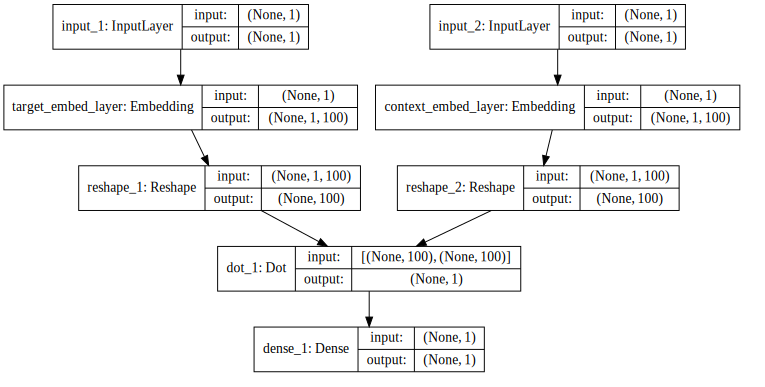

In [0]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi='70').create(prog='dot', format='svg'))

**6. Training the Model**

---



In [0]:
import numpy as np
for epoch in range(1, 6):
  epoch_loss = 0
  # in each epoch, train all the sentences, one per iteration=> batch_size = num_sents
  for i, sent_examples in enumerate(skip_grams):
    target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
    context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
    labels = np.array(sent_examples[1], dtype='int32')
    X = [target_wds, context_wds]
    Y = labels
    if i % 5000 == 0: # after 5000 sentences i.e. 5000 iterations
      print('Processed %d sentences' %i)
    if np.isnan(epoch_loss):
      print('epoch_loss====',epoch_loss, '     ,i =',i)
      print('target_wds == ',target_wds)
      print('context_wds == ',context_wds)
      print('X == ',X)
      print('Y == ',Y)
      print('model.train_on_batch(X, Y)====',model.train_on_batch(X, Y))
    epoch_loss += model.train_on_batch(X, Y)
  print('Processed all %d sentences' %i)
  print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')

Processed 0 sentences








Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 1 Loss: 2395.5568726183847 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 2 Loss: 1956.5782954704482 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 3 Loss: 1872.170565534616 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 4 Loss: 1825.6706945449114 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 5 Loss: 1801.6421593769337 



**7. Getting the Word Embeddings**

---



In [0]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0][1:]

Sanity Check:

In [0]:
print(word_embeddings.shape)

(10085, 100)


In [0]:
from pandas import DataFrame
print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

             0         1         2   ...        97        98        99
could  0.108196  0.099787 -0.107097  ... -0.154977  0.024048  0.091315
would -0.089229 -0.115439 -0.020785  ... -0.292064  0.116718 -0.051456
mr     0.187557 -0.164944  0.250270  ... -0.270778  0.059147 -0.115237
mrs    0.140330 -0.060169  0.028485  ... -0.160517  0.116114 -0.094252
must   0.144358  0.042229 -0.018545  ... -0.060639  0.144465 -0.109503
said   0.011484  0.017438 -0.054379  ... -0.169572 -0.039763  0.202826
one    0.041778  0.039071 -0.108136  ... -0.073580  0.140176 -0.126315
much  -0.066491  0.056805  0.079065  ... -0.180062  0.093707 -0.045447
miss  -0.001912 -0.136427  0.001051  ... -0.315563  0.131947 -0.013147
every -0.086329  0.065121 -0.104390  ...  0.147218  0.040775  0.150760

[10 rows x 100 columns]


**8. Measuring Similarity Between Word Pairs**

---



In [0]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(word_embeddings)

Sanity Check:

In [0]:
print(similarity_matrix.shape)

(10085, 10085)


**9. Exploring and Visualizing your Word Embeddings using t-SNE**

---



A. Get the most similar words to the search items in the list below

In [0]:
search_terms = ['man', 'love', 'hatred', 'woman', 'wisdom', 'kindness', 'god', 'man', 'folly', 'fool']
similar_words = {term: [idx2word[idx] for idx in (-1 * similarity_matrix[word2idx[term]-1]).argsort()[1:6] + 1] for term in search_terms}

Sanity Check:

In [0]:
print(similar_words)

{'man': ['young', 'suspect', 'thing', 'feeling', 'park'], 'love': ['convince', 'station', 'tea', 'times', 'opened'], 'hatred': ['extenuations', 'ingenuousness', 'attacking', 'hesitatingly', 'shuffling'], 'woman': ['ought', 'dear', 'regret', 'persuaded', 'came'], 'wisdom': ['clamour', 'unmodulated', 'landing', 'tittle', 'swelled'], 'kindness': ['leave', 'useful', 'danger', 'promised', 'tell'], 'god': ['thank', 'maps', 'mend', 'buildings', 'objectionable'], 'folly': ['woody', 'eat', 'resentment', 'struck', 'charge'], 'fool': ['produces', 'tippet', 'likelihood', 'twill', 'blushed']}


B. Plot the words in the dictionary above using t-SNE

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

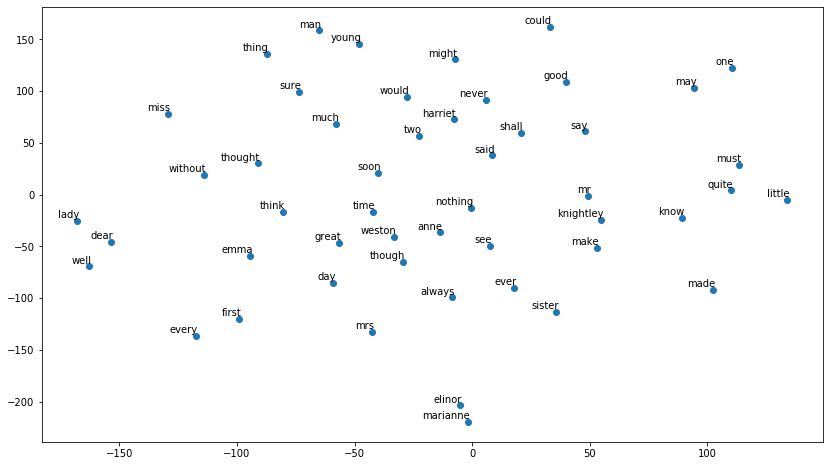

In [0]:
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50
T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')

● What would the inputs and outputs to the model be?


The inputs to the skip gram model is the one hot vector representing the input word and the output is the probability distribution for all the other words in the vocabulary. The word with the maximum probability has a higher likely chance of being in the neighbourhood of the input vector.

● How would you use the Keras framework to create this architecture?


We can use keras sequential api to build this model. We will have an input layer which takes one hot vector. The second layer will be a dense layer with embed_size units and linear activation function. The last layer will also be a dense layer with vocab_size units and softmax activation function.


● Can you think of reasons why this model is considered to be inefficient?

The skip gram model becomes inefficient because the model needs to learns around embed_size x vocab_size number of weights which is a large number given the limited data and can result in overfitting. 
Moreover the model can be inefficient as it depends largely on the training data and the context it provides. The training data captured from different sources can result in completely differnt embeddings for the same set of words (mainly for words which have different meaning in different contexts).